In [2]:
import av
from video import Video
path = '../videos/SOX5yA1l24A.mp4'

In [3]:
test_object = Video(path)

List of available streams:
{'video': [<av.VideoStream #0 h264, yuv420p 340x256 at 0x7f5c84e2bbb0>], 'audio': [<av.AudioStream #1 aac at 48000Hz, mono, fltp at 0x7f5c84e2bec0>]}
../videos/SOX5yA1l24A.mp4 
 	 default stream:  <av.VideoStream #0 h264, yuv420p 340x256 at 0x7f5c84e2bbb0>


In [43]:
# first seek into somewhere
test_object.seek(0, any_frame=True)

In [42]:
# then peak at the next packet
test_object.peak()

(0.16683333333333333, False)

In [49]:
# then call next to see what is the timestamp
frame, ts= test_object.next()
print(frame.shape)

(256, 340, 3)


# Implementing rudimentary read video function

### That supports most of the functionality from the current TV read_video function

In [13]:
import torch
import torchvision
torchvision.set_video_backend("pyav")
path = '../videos/SOX5yA1l24A.mp4'
def get_tv(path):
    vframes, aframes, _ = torchvision.io.read_video(path, end_pts=2.0, pts_unit="sec")
    return vframes.size(), aframes.size()

sa, sb = get_tv(path)
sizes = f"Expected sizes: {sa}, {sb}"
print(sizes)

Expected sizes: torch.Size([60, 256, 340, 3]), torch.Size([1, 0])


In [9]:
import torch
from torchvision import transforms as t


def read_video(vid, start=0, end=None, read_video=True, read_audio=True):
    if not isinstance(vid, Video):
        vid = Video(path)
    
    # safety checks - basic stuff
    if end is None:
        end = float("inf")
    if end < start:
        raise ValueError(
            "end_pts should be larger than start_pts, got "
            "start_pts={} and end_pts={}".format(start_pts, end_pts)
        )
    
    # safety checks, streams
    stream_types = [x for x in vid.available_streams.keys()]
    if read_video:
        assert "video" in stream_types
    if read_audio:
        assert "audio" in stream_types
    
    current_pts = start
    if read_video:
        video_frames = [] # video frame buffer 
    if read_audio:
        audio_frames = [] # audio frame buffer
    
    # this should get us close to the actual starting point we want
    vid.seek(start, stream="video", any_frame=True)
    
    while current_pts < end:
        if read_video:
            frame, current_pts = vid.next("video")
            if len(frame) > 0:
                video_frames.append(frame)
        if read_audio:
            frame, current_pts = vid.next("audio")
            if len(frame) > 0:
                audio_frames.append(frame)
    
    output = {'video': torch.stack([torch.tensor(v) for v in video_frames], 0) if read_video else torch.empty(0),
              'audio': torch.stack([torch.tensor(a) for a in audio_frames], 0) if read_audio else torch.empty(0)}
    
    return output

In [18]:
from video import Video
path = '../videos/SOX5yA1l24A.mp4'
test_object = Video(path, debug=False)
test = read_video(test_object, end=2.0, read_audio=False)

print(sizes)
print(test['video'].size())

Expected sizes: torch.Size([60, 256, 340, 3]), torch.Size([1, 0])
torch.Size([60, 256, 340, 3])


# Datasets using the new API

Using the new video-reading abstraction to write datasets

In [1]:
from dataset import GenericVideoDataset
from torchvision import transforms as t
transforms = [t.ToPILImage(), t.Resize((112, 112), interpolation=2), t.ToTensor()]
frame_transform = t.Compose(transforms)
ds = GenericVideoDataset("../dataset_files/", epoch_size=2000, frame_transform=frame_transform, from_keyframes=False)

In [3]:
from torch.utils.data import DataLoader
loader = DataLoader(ds, batch_size=12)
for i, b in enumerate(loader):
    if i < 1:
        print(b)

{'path': ['../dataset_files/class4/WUzgd7C1pWA.mp4', '../dataset_files/class3/v_SoccerJuggling_g23_c01.avi', '../dataset_files/class1/R6llTwEh07w.mp4', '../dataset_files/class4/WUzgd7C1pWA.mp4', '../dataset_files/class3/v_SoccerJuggling_g23_c01.avi', '../dataset_files/class3/TrumanShow_wave_f_nm_np1_fr_med_26.avi', '../dataset_files/class3/TrumanShow_wave_f_nm_np1_fr_med_26.avi', '../dataset_files/class1/RATRACE_wave_f_nm_np1_fr_goo_37.avi', '../dataset_files/class4/v_SoccerJuggling_g24_c01.avi', '../dataset_files/class4/WUzgd7C1pWA.mp4', '../dataset_files/class4/v_SoccerJuggling_g24_c01.avi', '../dataset_files/class3/v_SoccerJuggling_g23_c01.avi'], 'video': tensor([[[[[0.4706, 0.6078, 0.6549,  ..., 0.9922, 1.0000, 1.0000],
           [0.5294, 0.6235, 0.6706,  ..., 0.9961, 1.0000, 1.0000],
           [0.7176, 0.6784, 0.6863,  ..., 1.0000, 1.0000, 1.0000],
           ...,
           [0.4235, 0.4353, 0.4510,  ..., 0.3255, 0.3490, 0.3647],
           [0.4235, 0.4353, 0.4510,  ..., 0.3686,

## Kinetics

### Random style dataset

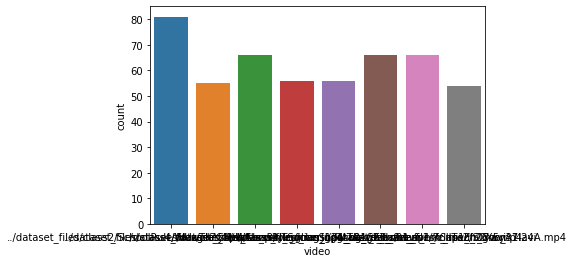

In [1]:
from kinetics import KineticsRandomDataset
from torchvision import transforms as t
transforms = [t.ToPILImage(), t.Resize((112, 112), interpolation=2), t.ToTensor()]
frame_transform = t.Compose(transforms)
ds = KineticsRandomDataset("../dataset_files/", epoch_size=500, frame_transform=frame_transform)
from torch.utils.data import DataLoader
loader = DataLoader(ds, batch_size=12)
d = {"video":[], 'start':[], 'end':[]}
for b in loader:
    for i in range(len(b['path'])):
        d['video'].append(b['path'][i])
        d['start'].append(b['start'][i].item())
        d['end'].append(b['end'][i].item())

import pandas as pd
df = pd.DataFrame.from_dict(d)
df.head()
        
import seaborn as sns
sns.countplot(data=df, x='video')

### Sequential dataest

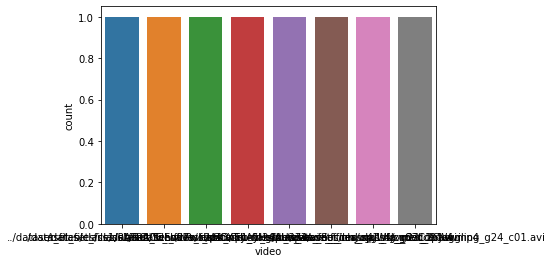

In [1]:
from kinetics import KineticsSequentialDataset
from torchvision import transforms as t

transforms = [t.ToPILImage(), t.Resize((112, 112), interpolation=2), t.ToTensor()]
frame_transform = t.Compose(transforms)
ds = KineticsSequentialDataset("../dataset_files/", epoch_size=None, frame_transform=frame_transform)
from torch.utils.data import DataLoader
loader = DataLoader(ds, batch_size=12)
d = {"video":[], 'start':[], 'end':[]}
for b in loader:
    for i in range(len(b['path'])):
        d['video'].append(b['path'][i])
        d['start'].append(b['start'][i].item())
        d['end'].append(b['end'][i].item())

import pandas as pd
df = pd.DataFrame.from_dict(d)
df.head()
        
import seaborn as sns
sns.countplot(data=df, x='video')

## AVA dataset

In [5]:
from AVA import AVADataset
from torchvision import transforms as t
transforms = [t.ToPILImage(), t.Resize((112, 112), interpolation=2), t.ToTensor()]
frame_transform = t.Compose(transforms)

ds = AVADataset("/work/bjuncek/AVA_actions/data/train/", "/work/bjuncek/AVA_actions/ava_train_v2.2.csv", 16, frame_transform=frame_transform )

In [6]:
from torch.utils.data import DataLoader
loader = DataLoader(ds, batch_size=1)
for b in loader:
    print(b)
    break

{'path': ['/work/bjuncek/AVA_actions/data/train/-5KQ66BBWC4.mkv'], 'video': tensor([[[[[0.0235, 0.0235, 0.0314,  ..., 0.0392, 0.0392, 0.0431],
           [0.0275, 0.0314, 0.0353,  ..., 0.0627, 0.0588, 0.0627],
           [0.0392, 0.0392, 0.0431,  ..., 0.0667, 0.0549, 0.0588],
           ...,
           [0.2549, 0.3255, 0.3176,  ..., 0.3176, 0.3176, 0.3451],
           [0.2745, 0.3176, 0.3176,  ..., 0.3490, 0.3569, 0.3882],
           [0.2824, 0.2549, 0.2627,  ..., 0.3020, 0.3059, 0.3137]],

          [[0.0431, 0.0431, 0.0392,  ..., 0.0588, 0.0627, 0.0706],
           [0.0471, 0.0471, 0.0431,  ..., 0.0824, 0.0824, 0.0941],
           [0.0588, 0.0549, 0.0510,  ..., 0.0980, 0.0902, 0.1020],
           ...,
           [0.4235, 0.5020, 0.5098,  ..., 0.4784, 0.4667, 0.4784],
           [0.4275, 0.4863, 0.5020,  ..., 0.5059, 0.4980, 0.5098],
           [0.4275, 0.4118, 0.4431,  ..., 0.4588, 0.4471, 0.4392]],

          [[0.0196, 0.0196, 0.0196,  ..., 0.0353, 0.0353, 0.0431],
           [0.023

# Keyframes dataset

Implementing dataset that simply returns a random keyframe from video

In [3]:
from keyframe_dataset import KFDataset
from torchvision import transforms as t
transforms = [t.ToPILImage(), t.Resize((112, 112), interpolation=2), t.ToTensor()]
frame_transform = t.Compose(transforms)
ds = KFDataset("../dataset_files/", transform=frame_transform)

In [4]:
from torch.utils.data import DataLoader
from itertools import islice
loader = DataLoader(ds, batch_size=2)
for b in loader:
    print(b['video'].size())

torch.Size([2, 3, 112, 112])
torch.Size([2, 3, 112, 112])
torch.Size([2, 3, 112, 112])
torch.Size([2, 3, 112, 112])
